# I] Import functions and options

In [23]:
import pandas, numpy, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})
from matplotlib_venn import venn2

In [24]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [25]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] Data download

In [26]:
%%time
# DL data ATG7 isoform expression
path = output_file_directory + "/ATG7/dataframes_for_input/df_ATG7_NormPrim.csv"
df_ATG7_NormPrim= pandas.read_csv(path, sep = ",")

#remove Survival information
df_ATG7_NormPrim.drop(df_ATG7_NormPrim.columns[[3, 4]], axis = 1, inplace = True)

print(df_ATG7_NormPrim.shape)
df_ATG7_NormPrim.head(2)

(16614, 20)
Wall time: 80.9 ms


,sample,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ATG7_3,ATG7_total,ATG7_1tpm,ATG7_2tpm,ATG7_3tpm,log2_p1_ATG7_total,log2_p1_ATG7_1,log2_p1_ATG7_2,ATG7_prot_tot,ATG7_1perc,ATG7_2perc,ATG7_3perc,ATG7_1norm,ATG7_2norm
0,GTEX-ZTTD-0326-SM-57WFW,Normal Tissue,Muscle,5.042,3.860,2.390,0.2642,32.944283,14.519306,5.240574,1.199970,5.085097,3.955992,2.641679,20.95985,69.271996,25.002916,5.725088,0.440723,0.159074
1,GTEX-PX3G-1626-SM-2S1PT,Normal Tissue,Muscle,4.252,2.322,1.956,1.1320,19.052710,4.999249,3.878848,2.190624,4.325725,2.584782,2.286540,11.06872,45.165557,35.043325,19.791118,0.262390,0.203585


In [27]:
#split to have Normal (GTEX) and Primary (TCGA)
df_ATG7_Normal = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('GTEX')]
print('Normal tissue smaples:', len(df_ATG7_Normal))
df_ATG7_Primary = df_ATG7_NormPrim[df_ATG7_NormPrim['sample'].str.startswith('TCGA')]
print('Primary tumors smaples:', len(df_ATG7_Primary))

Normal tissue smaples: 7429
Primary tumors smaples: 9185


# III] ATG7 expression

## A) ATG7 expression

In [28]:
#How many samples represent each organs?
all_data = [[df_ATG7_Normal, 'normal_tissue'], [df_ATG7_Primary, 'primary_tumor']]

for data in all_data: 
    print(data[1].upper())
    print(data[0]["Primary_Site"].value_counts())
    print('___________________________________')

NORMAL_TISSUE
Brain              1152
Esophagus           653
Blood Vessel        606
Skin                556
Adipose Tissue      515
Muscle              396
Heart               377
Blood               337
Colon               308
Lung                288
Thyroid             279
Nerve               278
Breast              179
Stomach             174
Pancreas            167
Testis              165
Adrenal Gland       128
Liver               110
Pituitary           107
Prostate            100
Spleen              100
Small Intestine      92
Ovary                88
Vagina               85
Uterus               78
Salivary Gland       55
Kidney               28
Cervix Uteri         10
Bladder               9
Fallopian Tube        5
Name: Primary_Site, dtype: int64
___________________________________
PRIMARY_TUMOR
Breast                     1092
Lung                       1011
Kidney                      884
Brain                       662
Head And Neck Region        518
Thyroid Gland          

In [29]:
all_data = [[df_ATG7_Normal, 'normal_tissue'], [df_ATG7_Primary, 'primary_tumor']]
df_sampletype_l  = []

for data in all_data:
    print(data[1].upper())
    
    ##select columns
    df_sampletype = data[0][['Primary_Site',
                        'ATG7_total',             
                        'ATG7_1perc',
                        'ATG7_2perc',
                        'ATG7_3perc']]
     
    ##Column rename
    df_sampletype = df_sampletype.rename(columns = {'Primary_Site' : 'Primary Site', 
                                                    'ATG7_total': 'tpm ATG7',
                                                    'ATG7_1perc' : "% ATG7(1)",
                                                    'ATG7_2perc' : "% ATG7(2)",
                                                    'ATG7_3perc' : "% ATG7(3)"})
    
    ##Find all the elements where "n" is < 15 and save it in a list
    working_elements = df_sampletype["Primary Site"].to_list()
    print(df_sampletype.shape)
    
    element_to_delete = []
    for element in working_elements:
        if working_elements.count(element) < 15:
            element_to_delete.append(element)

    ##convert the list to dict to remove duplicate
    element_to_delete = list(dict.fromkeys(element_to_delete))
    print('elements with less than 20 samples are:', element_to_delete)

    ##Remove the samples where the tissue is represented less than 20 times
    for element in element_to_delete:
        df_sampletype = df_sampletype.loc[df_sampletype["Primary Site"] != element]
    print('shape after removing the elements', df_sampletype.shape)
    print("means: \n", df_sampletype.mean().round(1))
    
    ##Groupby to have merge of all the primary site 
    df_sampletype= df_sampletype.groupby('Primary Site').agg(numpy.mean)
    df_sampletype = df_sampletype.round(2)
    
    ##save_df in a list
    df_sampletype_l.append(df_sampletype)
    print()
    print(df_sampletype.head())
    print('___________________________________')    
    

df_sampletype_normal = df_sampletype_l[0]
df_sampletype_primary = df_sampletype_l[1]

NORMAL_TISSUE
(7429, 5)
elements with less than 20 samples are: ['Fallopian Tube', 'Cervix Uteri', 'Bladder', nan]
shape after removing the elements (7405, 5)
means: 
 tpm ATG7     11.2
% ATG7(1)    81.5
% ATG7(2)    15.2
% ATG7(3)     3.3
dtype: float64

                tpm ATG7  % ATG7(1)  % ATG7(2)  % ATG7(3)
Primary Site                                             
Adipose Tissue     13.21      79.11      17.60       3.29
Adrenal Gland      11.60      78.83      17.67       3.50
Blood              13.52      39.14      47.83      13.04
Blood Vessel       14.23      85.50      12.12       2.38
Brain               7.94      94.98       4.08       0.94
___________________________________
PRIMARY_TUMOR
(9185, 5)
elements with less than 20 samples are: []
shape after removing the elements (9185, 5)
means: 
 tpm ATG7     15.1
% ATG7(1)    71.5
% ATG7(2)    21.2
% ATG7(3)     7.3
dtype: float64

               tpm ATG7  % ATG7(1)  % ATG7(2)  % ATG7(3)
Primary Site                         

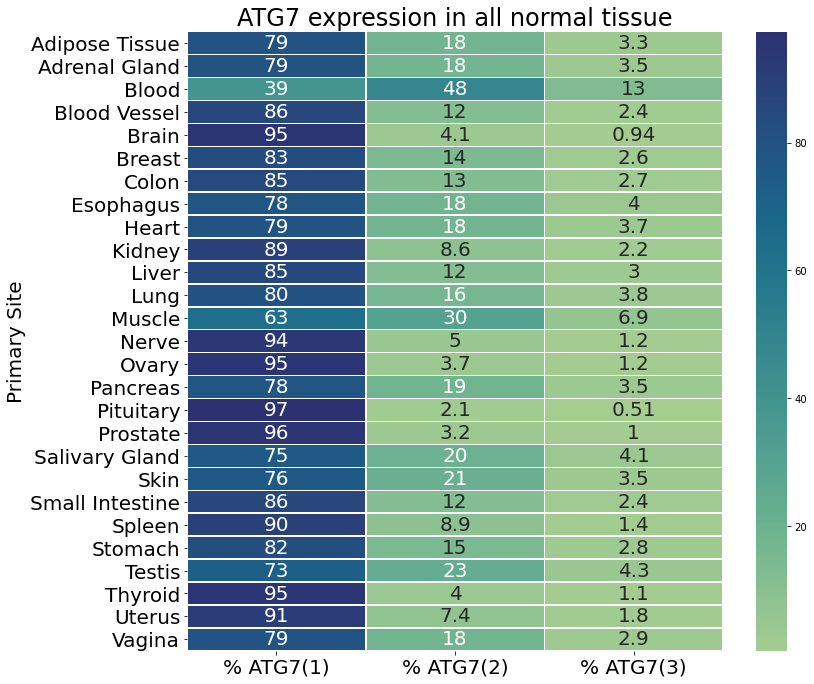

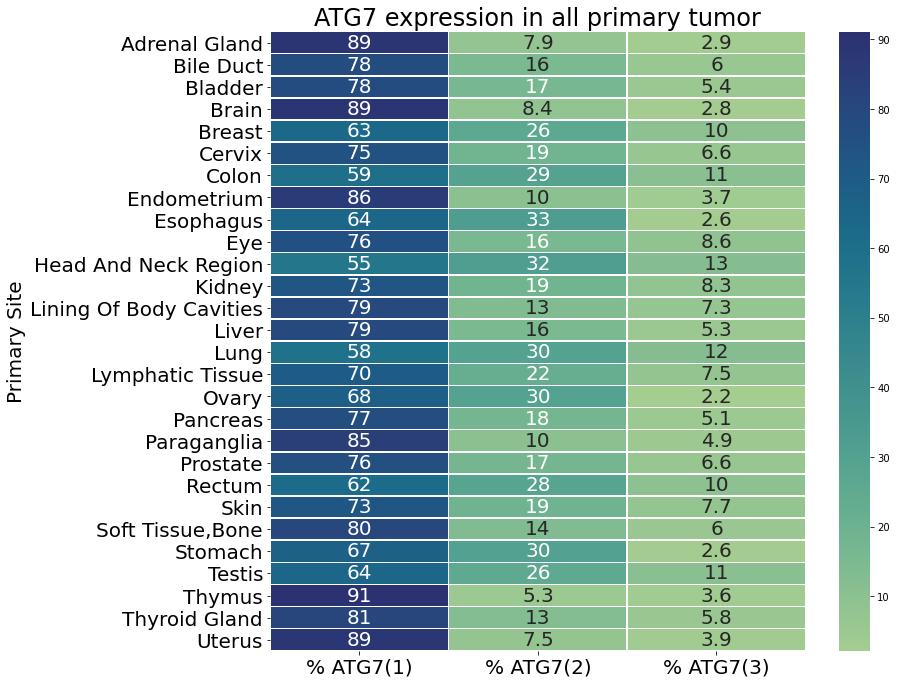

<Figure size 864x576 with 0 Axes>

In [22]:
all_data = [[df_sampletype_normal, 'normal tissue'], [df_sampletype_primary, 'primary tumor']]

for data in all_data:
    df = data[0]
    label = data[1]

    HeatMap_df = df[['% ATG7(1)', '% ATG7(2)', '% ATG7(3)']]
    heatmap = seaborn.heatmap(HeatMap_df, annot=True, cmap="crest", linewidths=.5)
    plt.title('ATG7 expression in all '+label)
    plt.yticks(fontsize=20)
    plt.subplots_adjust(top=1.2)
    
    path = 'ATG7/figs_ATG7_characterisation/'
    name = 'heatmap_organs_' + label
    plt.savefig(output_file_directory+path+name+'.svg')
    plt.show()
    plt.clf()

normal tissue
     Primary Site  tpm ATG7
0  Adipose Tissue     13.21
1   Adrenal Gland     11.60
2           Blood     13.52
min: 3.68
max: 22.56


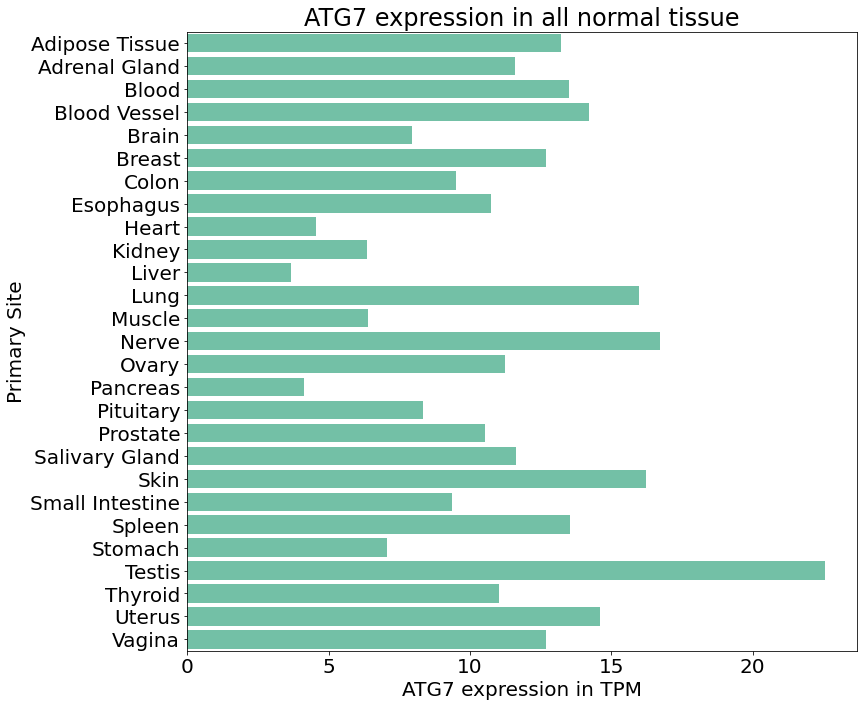

primary tumor
    Primary Site  tpm ATG7
0  Adrenal Gland     11.35
1      Bile Duct     10.67
2        Bladder     18.77
min: 8.27
max: 26.4


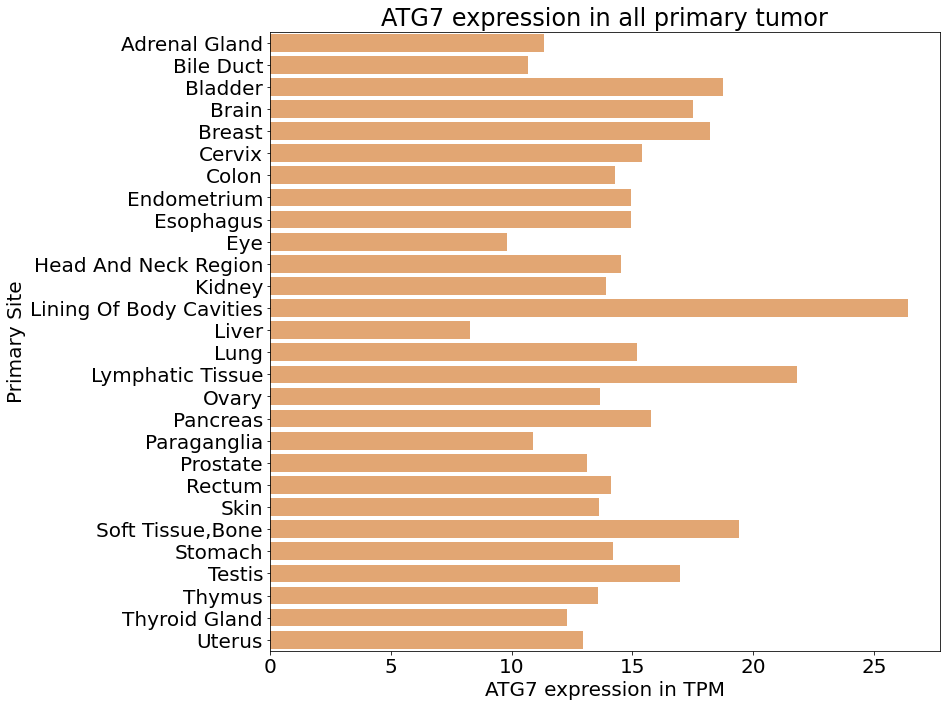

<Figure size 864x576 with 0 Axes>

In [41]:
all_data = [[df_sampletype_normal, 'normal tissue', 'mediumaquamarine'], 
            [df_sampletype_primary, 'primary tumor', 'sandybrown']]

for data in all_data:
    df = data[0]
    label = data[1]
    color_ = data[2]
    
    print(label)
    hist_df = df.reset_index()
    hist_df = hist_df[['Primary Site','tpm ATG7']]
    print(hist_df.head(3))
    print("min:", hist_df['tpm ATG7'].min())
    print("max:", hist_df['tpm ATG7'].max())
    
    # Seaborn
    seaborn.barplot(data = hist_df, x =  'tpm ATG7', y = 'Primary Site', color = color_)
    plt.title('ATG7 expression in all '+ label)
    plt.xlabel('ATG7 expression in TPM')
    plt.subplots_adjust(top=1.2)
    plt.yticks(fontsize=20)
    
    path = 'ATG7/figs_ATG7_characterisation/'
    name = 'histo_organs_' + label
    plt.savefig(output_file_directory+path+name+'.svg')
    plt.show()
    plt.clf()

In [38]:
hist_df['tpm ATG7'].min()

3.68

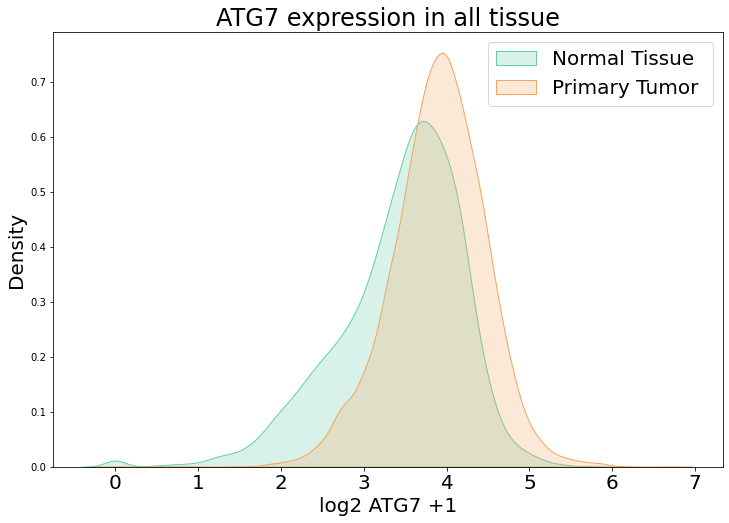

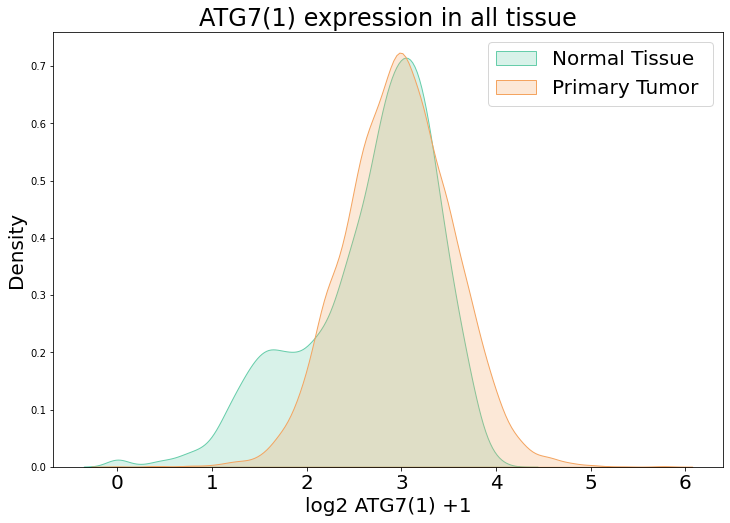

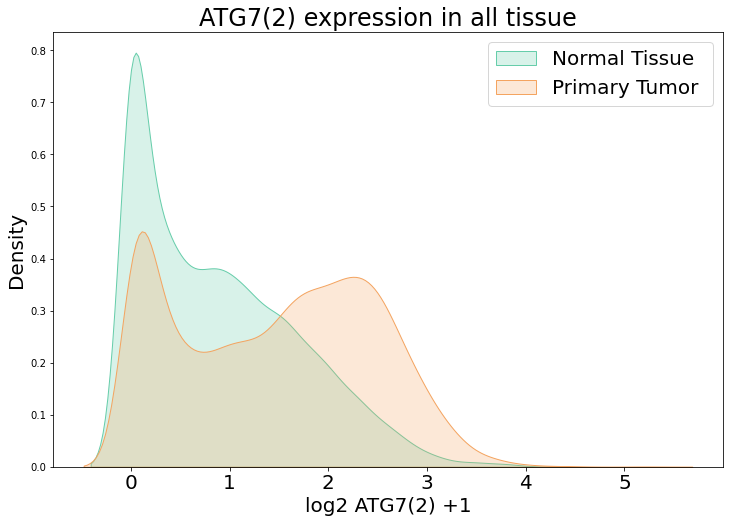

<Figure size 864x576 with 0 Axes>

In [10]:
# Distribution graph, for ATG7, iso1 & iso2
all_dfs = [[df_ATG7_Normal, 'in all tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = [['log2_p1_ATG7_total', 'ATG7'], ['log2_p1_ATG7_1', 'ATG7(1)'], ['log2_p1_ATG7_2', 'ATG7(2)']]


for df in all_dfs:
  for isoform in isoforms:
    xData = df[0][isoform[0]]
    x2Data = df[2][isoform[0]]

    seaborn.kdeplot(xData, color = 'mediumaquamarine', fill = True)
    seaborn.kdeplot(x2Data, color = 'sandybrown', fill = True)

    plt.xlabel('log2 '+ isoform[1]+ ' +1')
    plt.title(isoform[1]+ ' expression ' + df[1] )
    plt.legend(labels=["Normal Tissue","Primary Tumor "])
    title_file = 'distrib_' + isoform[1]
    path = 'ATG7/figs_ATG7_characterisation/'
    plt.savefig(output_file_directory+path+title_file+'.svg')
    plt.show()
    plt.clf()

## B) Percentage do not express ATG7 isoforms

In [11]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'all normal tissue'], [df_ATG7_Primary, 'all primary tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)'], ['ATG7_3tpm', 'ATG7(3)']]

for df in all_dfs:
  print(df[1].upper())
  for isoform in isoforms:
        
    what = isoform[1]
    all_ = (df[0][isoform[0]]).shape
    no_exp = (df[0][isoform[0]]<0.1).sum()
    perc_no_exp = (no_exp*100)/all_
    perc_no_exp = float(perc_no_exp)

    # print("The percentage of patient who do not express", QUOI, OU, "is:", round(perc_no_exp,1),'%')
    print(round(perc_no_exp,1),'% of tumor do not express', what)
  print()


ALL NORMAL TISSUE
0.4 % of tumor do not express ATG7
0.4 % of tumor do not express ATG7(1)
24.3 % of tumor do not express ATG7(2)
59.2 % of tumor do not express ATG7(3)

ALL PRIMARY TUMOR
0.0 % of tumor do not express ATG7
0.0 % of tumor do not express ATG7(1)
13.4 % of tumor do not express ATG7(2)
33.6 % of tumor do not express ATG7(3)



In [12]:
#Percentage of patients: 
all_dfs = [[df_ATG7_Normal, 'Normal Tissue'], [df_ATG7_Primary, 'Primary Tumor']]

isoforms = [['ATG7_total', 'ATG7'], ['ATG7_1tpm', 'ATG7(1)'], 
            ['ATG7_2tpm', 'ATG7(2)']]

df_number_exp = []
what = []
sample_type = []
who_dontexp = []
perc_noexp = []
    
for df in all_dfs:
    for isoform in isoforms:
        #save what isoform
        what.append(isoform[1])
        #save sample_type
        sample_type.append(df[1])
        #have total sample number
        all_ = (df[0][isoform[0]]).shape
        #calculate number of sample who express the isoform
        without_exp = (df[0][isoform[0]]<0.1).sum()
        who_dontexp.append(without_exp)
        #convert result to percentage
        perc_without_exp = float((without_exp*100)/all_)   
        perc_noexp.append(round(perc_without_exp,1))

        #create a dictionnary and convert to dataframe
        d = dict(Isoforms = what, who_dontexp = who_dontexp, 
                 Percentage = perc_noexp, Sample_Type = sample_type)
        df_noexpr_distrib = pandas.DataFrame.from_dict(d, orient='index')
        df_noexpr_distrib = df_noexpr_distrib.T
          
df_noexpr_distrib


,Isoforms,who_dontexp,Percentage,Sample_Type
0,ATG7,27,0.4,Normal Tissue
1,ATG7(1),27,0.4,Normal Tissue
2,ATG7(2),1805,24.3,Normal Tissue
3,ATG7,1,0,Primary Tumor
4,ATG7(1),1,0,Primary Tumor
5,ATG7(2),1231,13.4,Primary Tumor


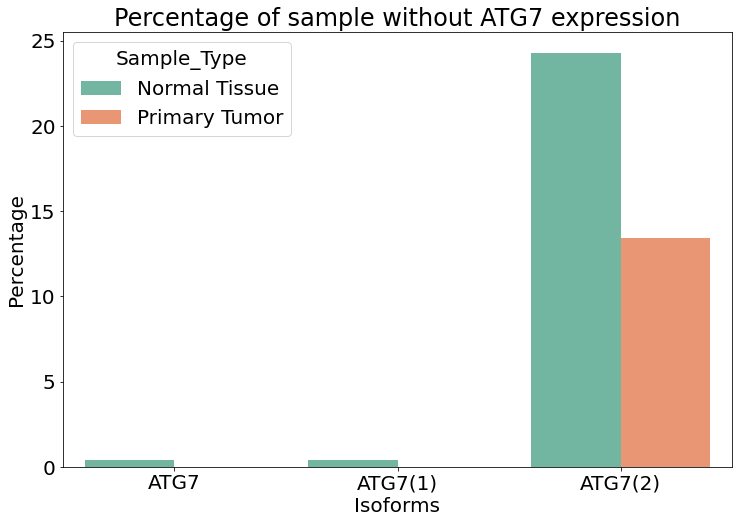

In [13]:
seaborn.barplot(data=df_noexpr_distrib, x="Isoforms", y="Percentage", hue="Sample_Type", 
                palette = 'Set2', orient = 'v')
plt.title("Percentage of sample without ATG7 expression")
plt.yticks(fontsize=20)

path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'percentage_expression.svg')

## C) Expression figures

### 1) Value TPM

16614


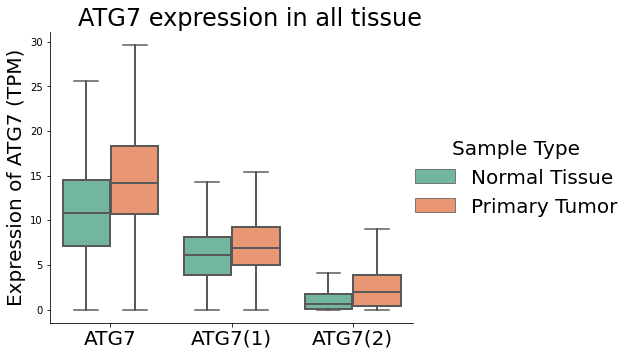

In [14]:
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(7,10)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7'
data_distrib.loc[shape: shape*2,'x'] = 'ATG7(1)'
data_distrib.loc[shape*2:,'x'] = 'ATG7(2)'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('Expression of ATG7 (TPM)')
plt.xlabel('')
plt.title('ATG7 expression in '+ info, x=.55)

#save
path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'ATG7_exp_alltissue.svg')

In [15]:
#Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_total', 'ATG7_1tpm', 'ATG7_2tpm']

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


the pvalue between all normal tissue(10.837) and all primary tumors(14.122) for ATG7_total is 0.000E+00
the pvalue between all normal tissue(6.129) and all primary tumors(6.858) for ATG7_1tpm is 6.188E-109
the pvalue between all normal tissue(0.670) and all primary tumors(1.930) for ATG7_2tpm is 0.000E+00



In [16]:
#median brut file to compare 
print(df_ATG7_NormPrim['ATG7_total'].mean())
print(df_ATG7_NormPrim['ATG7_1tpm'].mean())
print(df_ATG7_NormPrim['ATG7_2tpm'].mean())

13.330134367799564
6.849488322969236
1.8954335752090787


In [17]:
#median after modification to be sure I selected the good ones
data_distribtest = data_distrib[data_distrib['x'] == 'ATG7']
data_distribtest1 = data_distrib[data_distrib['x'] == 'ATG7(1)']
data_distribtest2 = data_distrib[data_distrib['x'] == 'ATG7(2)']
print(data_distribtest.mean())
print(data_distribtest1.mean())
print(data_distribtest2.mean())

y    13.330134
dtype: float64
y    6.849488
dtype: float64
y    1.895434
dtype: float64


### 2) Normalized

16614


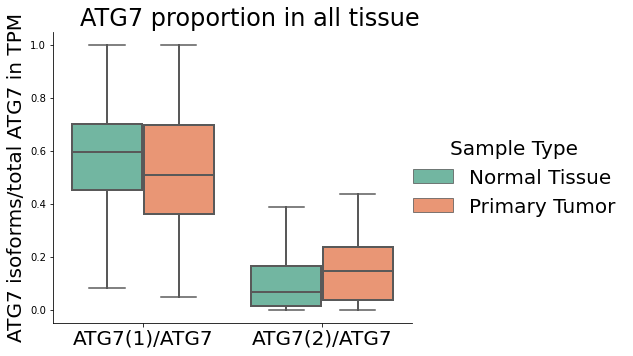

In [18]:
# NORMALiZED Distribution: Data preparation + graph
# Distribution: Data preparation + graph
Data = df_ATG7_NormPrim
info = 'all tissue'

shape = Data.shape
shape = shape[0]
print(shape)

#select the sample type column
sample_type = {'sample_type':[Data.iloc[:,1][i]
  for i in range(0, shape)]}

#convert to df, and copy it 3 times
sample_typedf = pandas.DataFrame(sample_type)
sample_typedf = pandas.concat([sample_typedf,sample_typedf,sample_typedf])
sample_typedf.reset_index(drop=True, inplace=True)

# Y for expression value 
y = {'y':[Data.iloc[:,j][i]
  for j in range(18,20)
    for i in range(0, shape)]}

#create df with Y 
data_distrib = pandas.DataFrame(y)

# X for ATG7/iso1/iso2                              
data_distrib.loc[:shape,'x'] = 'ATG7(1)/ATG7'
data_distrib.loc[shape:,'x'] = 'ATG7(2)/ATG7'

# Will be used for Hue
data_distrib['Sample Type'] = sample_typedf['sample_type']

#graph
seaborn.catplot(x="x", y="y", hue="Sample Type", aspect= 1.2, kind="box", palette = 'Set2', data = data_distrib, 
              boxprops={'lw':2}, medianprops={'lw':2}, whiskerprops={'lw':2}, showcaps=True, showfliers=False)

plt.ylabel('ATG7 isoforms/total ATG7 in TPM')
plt.xlabel('')
plt.title('ATG7 proportion in '+ info, x=0.55)

#save graph
path = 'ATG7/figs_ATG7_characterisation/'
plt.savefig(output_file_directory+path+'prop_alltissue.svg')



In [19]:
#NORMALIZED Distribution: Stats for all 

all_dfs = [[df_ATG7_Normal, 'all normal tissue', df_ATG7_Primary, 'all primary tumors']]

isoforms = ['ATG7_1norm', 'ATG7_2norm']
print('NORMALIZED')

for df in all_dfs:
  for isoform in isoforms:

    n1 = "{:.3f}".format(numpy.median(df[0][isoform]))
    n2 = "{:.3f}".format(numpy.median(df[2][isoform]))

    # Mann-Whitney analysis 
    statistic, pvalue = scipy.stats.mannwhitneyu(df[0][isoform], df[2][isoform])
    Pvalue = "{:.3E}".format(pvalue)
    print("the pvalue between", df[1]+'('+n1+')', "and", df[3]+'('+n2+')', "for", isoform, 'is', Pvalue)
  print()


NORMALIZED
the pvalue between all normal tissue(0.595) and all primary tumors(0.507) for ATG7_1norm is 2.372E-53
the pvalue between all normal tissue(0.068) and all primary tumors(0.146) for ATG7_2norm is 8.074E-187



## D) Correlation between the two isoforms

In [20]:
#Remove the 0.5% extremities to have a nicer graph
tissues = [[df_ATG7_Normal, "Normal tissue"], [df_ATG7_Primary, "Primary tumor"]]
isoforms = ['ATG7_1', 'ATG7_2']
df_final = []

for tissue in tissues:
 
    #Remove 0.5% extremities
    df_no_extrem = []
    for isoform in isoforms:
        print(tissue[1], ':', tissue[0].shape)
        #sort by value, 
        for_isoforms = tissue[0].sort_values([isoform], ascending = False)
        print(isoform)
        
        #remove the extremities
        lenght = len(for_isoforms)
        without_05perc = int(lenght*0.005)
        print('', without_05perc, 'are removed from head and tail')
        without_head = without_05perc
        without_tail = lenght - without_05perc
                
        df_no_extremities = for_isoforms.iloc[without_head:without_tail,:]
        print(' without extremities:', df_no_extremities.shape)
        print()
        df_no_extrem.append(df_no_extremities)
        
    #drop the unfiltered column ATG7_2 ([0]) and replace it with the filtered one ([1]) 
    df_no_extrem[0].pop("ATG7_2")
    #add column ATG7_2 (filtered one) at the correct position
    df_no_extrem[0].insert(5, "ATG7_2", df_no_extrem[1]['ATG7_2'])
    #remove NaN (the deleted samples for the two isoform)
    df = df_no_extrem[0].dropna(axis=0)
    df_final.append(df)
    print('df_final after merge of the two filtered columns:', df.shape)
    print('________________________')
    #now, need to compute the two isoform with sample name.

Normal tissue : (7429, 20)
ATG7_1
 37 are removed from head and tail
 without extremities: (7355, 20)

Normal tissue : (7429, 20)
ATG7_2
 37 are removed from head and tail
 without extremities: (7355, 20)

df_final after merge of the two filtered columns: (7278, 20)
________________________
Primary tumor : (9185, 20)
ATG7_1
 45 are removed from head and tail
 without extremities: (9095, 20)

Primary tumor : (9185, 20)
ATG7_2
 45 are removed from head and tail
 without extremities: (9095, 20)

df_final after merge of the two filtered columns: (9007, 20)
________________________


The correlation between iso1 and iso2 in Normal tissue is: 0.013738584652820428 0.24123356889124467


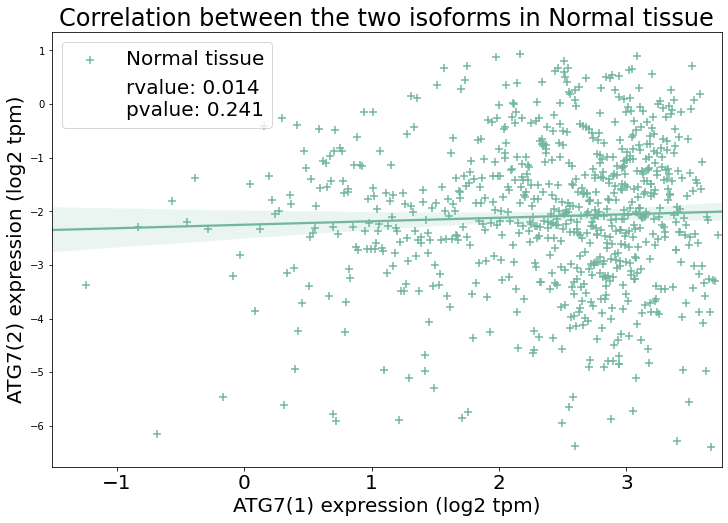


The correlation between iso1 and iso2 in Primary tumor is: -0.19973449926291995 1.0362617009482937e-81


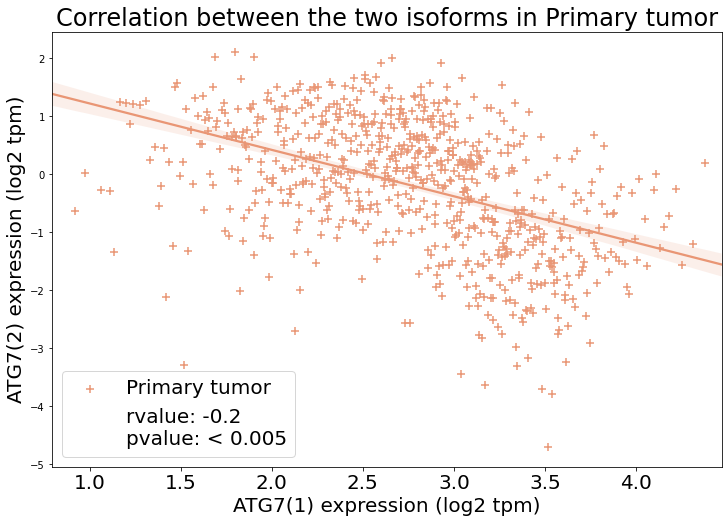

<Figure size 864x576 with 0 Axes>

In [21]:
#Graph and stats_ spearman correlation
#graph
df_final
color1 = '#72B6A1'
color2 = '#e99675'

normal_tissues = [df_final[0], "Normal tissue", '0.241', color1]
primary_tissues = [df_final[1], "Primary tumor", "< 0.005", color2]
tissues_no_extrem = normal_tissues, primary_tissues

for tissue in tissues_no_extrem:
    x = tissue[0]['ATG7_1'].to_list()
    y = tissue[0]['ATG7_2'].to_list()    
    
    #stat Spearman correlation 
    r_value, p_value = scipy.stats.spearmanr(x, y)
    print("The correlation between iso1 and iso2 in",tissue[1],"is:", r_value, p_value)
    
    #graph
    seaborn.regplot(x=x,y=y, x_bins=800, x_ci = 0, marker="+", label = tissue[1], color = tissue[3])
    seaborn.regplot(x=[],y=[], marker=" ", label= 'rvalue: '+str(round(r_value,3))+ "\npvalue: "+str(tissue[2]))

    name = "Correlation between the two isoforms in " + tissue[1]
    plt.title(name)
    plt.xlabel("ATG7(1) expression (log2 tpm)")
    plt.ylabel('ATG7(2) expression (log2 tpm)')

    plt.legend()

    #save
    path = 'ATG7/figs_ATG7_characterisation/'
    title_file = 'ATG7s_corr_' + tissue[1]
    plt.savefig(output_file_directory+path+title_file+'.svg')

    plt.show()  
    plt.clf()
    print()